# dLDS with Latent States: A Beginner-Friendly Demo

## What is dLDS?

**dLDS** (decomposed Linear Dynamical System) is a method for understanding how neural activity evolves over time.

### The Big Picture

Imagine you're recording from 100 neurons. That's a lot of data! But often, the "real" activity lives in a much smaller space — maybe just 5-10 dimensions. Think of it like this:

- **What you observe**: 100 neurons firing (high-dimensional, messy)
- **What's actually happening**: A few key patterns combining in different ways (low-dimensional, interpretable)

### The Math (Don't Panic!)

dLDS assumes your data follows two simple rules:

1. **Observation model**: `y_t = D @ x_t`
   - `y_t` = what you measure (100 neurons)
   - `x_t` = the hidden "latent" state (maybe 5 dimensions)
   - `D` = a mixing matrix that maps latent → observed

2. **Dynamics model**: `x_t = (Σ c_m * F_m) @ x_{t-1}`
   - The latent state evolves over time
   - `F_m` = different "dynamics operators" (like different movement patterns)
   - `c_m` = coefficients that blend these operators (changes over time!)

### Why is this useful?

- **Dimensionality reduction**: Go from 100 neurons to 5 interpretable dimensions
- **Discover dynamics**: Find the "building blocks" of neural activity
- **Handle non-stationarity**: The coefficients `c` can change, capturing switching behaviors

---
## Step 0: Install and Import

First, let's load the packages we need.

In [45]:
# Standard scientific Python
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Reload dLDS modules
modules_to_remove = [key for key in sys.modules.keys() if 'dlds' in key]
for mod in modules_to_remove:
    del sys.modules[mod]

# The dLDS package
from dlds import dLDS_with_latents, dLDS_config
from dlds.viz import *

# Make plots look nice
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

print("All imports successful!")

reloadjj
All imports successful!


In [46]:
try:
    from tqdm.auto import tqdm
    HAS_TQDM = True
except ImportError:
    HAS_TQDM = False
HAS_TQDM    

True

---
## Step 1: Load Your Data

We'll load neural recordings stored as a `.npy` file.

**Expected format**: `(neurons × time × trials)`

For example: 50 neurons, 1000 time points, 10 trials → shape `(50, 1000, 10)`

In [47]:
# Set up file paths
# CHANGE THESE to match your data location!
data_directory = os.getcwd() + os.sep + 'example_data'
data_name = r'data_hippo_multi_xmin_0_xmax_n_ymin_0_ymax_n.npy'
data_full_path = os.path.join(data_directory, data_name)


# Load the data
data_tensor = np.load(data_full_path)  # neurons × time × trials
# take a smaller subset for computational efficiency
data_tensor = data_tensor[:20, :,:4]
data_tensor = [gaussian_convolve(data_tensor[:,:,trial], direction = 1, wind = 11) for trial in range(data_tensor.shape[2])]
data_tensor = np.stack(data_tensor, axis=2)  # neurons × time × trials
print("Data loaded successfully!")
print(f"Shape: {data_tensor.shape}")
print(f"  - {data_tensor.shape[0]} neurons")
print(f"  - {data_tensor.shape[1]} time points")
print(f"  - {data_tensor.shape[2]} trials")

Data loaded successfully!
Shape: (20, 100, 4)
  - 20 neurons
  - 100 time points
  - 4 trials


In [48]:
# Convert to list of trials
# dLDS expects a list where each element is (neurons × time) for one trial

n_neurons, n_time, n_trials = data_tensor.shape
y_list = [data_tensor[:, :, trial_idx] for trial_idx in range(n_trials)]

print(f"Converted to list of {len(y_list)} trials")
print(f"Each trial has shape: {y_list[0].shape}")

Converted to list of 4 trials
Each trial has shape: (20, 100)


---
## Step 2: Preprocess the Data

### Why normalize?

Raw neural data often has:
- Very small values (e.g., 0 to 0.1)
- Different scales across neurons (some fire a lot, some barely fire)
- "Dead" neurons that don't do anything

Normalization fixes these issues and helps the model converge properly.

### What we'll do:
1. **Remove inactive neurons** — if a neuron barely changes, it's not informative
2. **Percentile normalization** — scale each neuron to a similar range using the 5th and 95th percentiles (robust to outliers)

In [49]:
# Concatenate all trials to compute global statistics
y_all = np.concatenate(y_list, axis=1)
print(f"Combined data shape: {y_all.shape}")

# Check the raw data range
print(f"\nRaw data statistics:")
print(f"  Min: {y_all.min():.6f}")
print(f"  Max: {y_all.max():.6f}")
print(f"  Std: {y_all.std():.6f}")

Combined data shape: (20, 400)

Raw data statistics:
  Min: 0.000000
  Max: 189.665872
  Std: 19.383892


In [50]:
# Compute percentiles for each neuron
p5 = np.percentile(y_all, 5, axis=1, keepdims=True)   # 5th percentile (low)
p95 = np.percentile(y_all, 95, axis=1, keepdims=True) # 95th percentile (high)

# Find "active" neurons (those with some dynamic range)
# If p95 - p5 is tiny, the neuron is basically flat/dead
active_neurons = ((p95 - p5) > 1e-6).flatten()

print(f"Keeping {np.sum(active_neurons)} / {len(active_neurons)} neurons")
print(f"Removed {len(active_neurons) - np.sum(active_neurons)} inactive neurons")

Keeping 18 / 20 neurons
Removed 2 inactive neurons


In [51]:
# Keep only active neurons
y_list = [y[active_neurons, :] for y in y_list]
y_all = y_all[active_neurons, :]


print(f"New data shape per trial: {y_list[0].shape}")

New data shape per trial: (18, 100)


In [52]:
# Normalize each trial
# Formula: y_normalized = (y - p5) / (p95 - p5)
# This maps the 5th percentile to 0 and 95th percentile to 1

y_list_normalized = y_list.copy() # no need for normalization here. You may need to normalize, depending on your data

print("Normalization complete!")
print(f"\nNormalized data statistics:")
print(f"  Min: {y_list_normalized[0].min():.3f}")
print(f"  Max: {y_list_normalized[0].max():.3f}")
print(f"  Std: {np.std(y_list_normalized[0]):.3f}")

Normalization complete!

Normalized data statistics:
  Min: 0.000
  Max: 138.174
  Std: 18.322


---
## Step 3: Visualize the Raw Data

Before fitting a model, always look at your data!

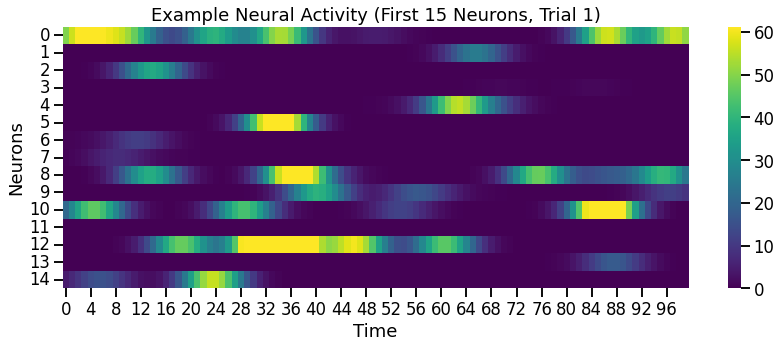

In [53]:
# Plot a few neurons from the first trial
y_example = y_list[0]

fig, ax = plt.subplots(figsize=(12, 5))

n_to_plot = min(15, y_example.shape[0])
sns.heatmap(y_example[:n_to_plot, :], cmap='viridis', cbar=True, ax=ax, robust = True)

ax.set_xlabel('Time')
ax.set_ylabel('Neurons')
ax.set_title('Example Neural Activity (First 15 Neurons, Trial 1)')

plt.tight_layout()
plt.show()

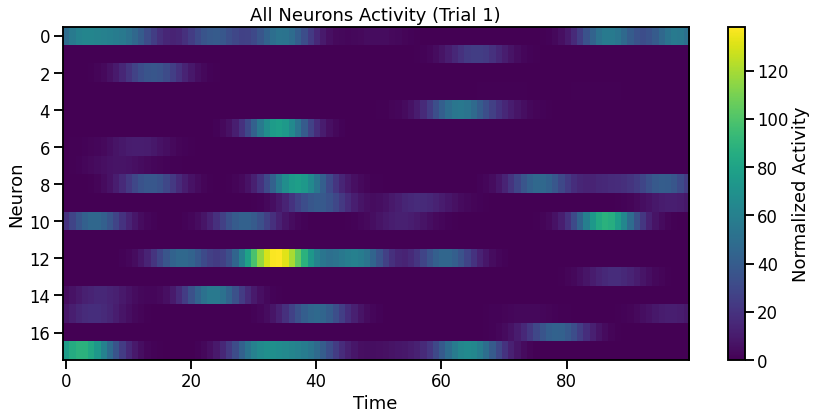

In [54]:
# Heatmap of all neurons
fig, ax = plt.subplots(figsize=(12, 6))

im = ax.imshow(y_example, aspect='auto', cmap='viridis')
ax.set_xlabel('Time')
ax.set_ylabel('Neuron')
ax.set_title('All Neurons Activity (Trial 1)')
plt.colorbar(im, ax=ax, label='Normalized Activity')
plt.tight_layout()
plt.show()

---
## Step 4: Set Up the dLDS Model

Now the fun part! Let's configure and create our model.

### Key Parameters

| Parameter | What it does | Typical values |
|-----------|--------------|----------------|
| `num_subdyns` | Number of dynamics operators (F matrices) | 3-15 |
| `latent_dim` | Dimension of the latent space | 5-20 (or ~10-20% of neurons) |
| `reg_term` | Sparsity regularization on coefficients | 0.1-5.0 |
| `smooth_term` | Smoothness regularization | 0.01-1.0 |
| `max_iter` | Maximum fitting iterations | 100-500 |

In [55]:
# Model settings
obs_dim = y_list_normalized[0].shape[0]  # Number of neurons we're using
latent_dim = int(0.3 * obs_dim)          # Latent dim = 15% of observed dim
num_subdyns = 5                         # Number of dynamics operators

print("Model Configuration:")
print(f"  Observation dim: {obs_dim} (number of neurons)")
print(f"  Latent dim: {latent_dim} (compressed representation)")
print(f"  Num dynamics: {num_subdyns} (number of F matrices)")
print(f"  Compression ratio: {obs_dim/latent_dim:.1f}x")

Model Configuration:
  Observation dim: 18 (number of neurons)
  Latent dim: 5 (compressed representation)
  Num dynamics: 5 (number of F matrices)
  Compression ratio: 3.6x


In [112]:
# Create the model
model = dLDS_with_latents(
    num_subdyns=num_subdyns,      # Number of dynamics operators
    latent_dim=latent_dim,        # Latent space dimension
    solver= 'spgl1',                 # Solver type ('inv' or 'spgl1')
    reg_term=0.8,                 # Sparsity on coefficients (higher = sparser)
    smooth_term=0.5,              # Smoothness on coefficients
    step_f=20.0,                  # Step size for F updates
    max_iter=200,                 # Maximum iterations
    max_error_relative=1e-6,      # Convergence threshold
    verbose=1  ,                   # Print progress (0=silent, 1=verbose)
    lambda_dyn = 5
)

print("Model created successfully!")

Model created successfully!


---
## Step 5: Fit the Model

This is where the magic happens. The model will:

1. Initialize D (observation matrix) using PCA
2. Alternate between updating:
   - Latent states `x`
   - Dynamics operators `F`
   - Coefficients `c`
   - Observation matrix `D`

**This may take a few minutes depending on your data size.**

In [ ]:
# Fit the model!
print("Fitting model... (this may take a few minutes)")
print("=" * 60)

result = model.fit(
    y_list_normalized,
    latent_dim=latent_dim,
    init_D='random',              # Initialize D with PCA (good starting point)
    normalize_D_cols=True,      # Keep D columns normalized

)

print("=" * 60)
print("Fitting complete!")

In [121]:
# Check the results
print("\nResults Summary:")
print(f"  Final error: {result.final_error:.6f}")
print(f"  Converged: {result.converged}")
print(f"  Iterations: {result.n_iterations}")


Results Summary:
  Final error: 1061.048874
  Converged: False
  Iterations: 400


In [122]:
# Extract the learned components
learned_F = result.F                          # List of dynamics operators
learned_D = result.D                          # Observation matrix
learned_x = result.x[0]                       # Latent states (trial 1)
learned_c = result.dynamic_coefficients[0]   # Coefficients (trial 1)

print("\nLearned Components:")
print(f"  D (observation matrix): {learned_D.shape}")
print(f"  x (latent states): {learned_x.shape}")
print(f"  c (coefficients): {learned_c.shape}")
print(f"  F (dynamics): {len(learned_F)} matrices, each {learned_F[0].shape}")


Learned Components:
  D (observation matrix): (18, 5)
  x (latent states): (5, 100)
  c (coefficients): (5, 99)
  F (dynamics): 5 matrices, each (5, 5)


---
## Step 6: Visualize the Results

Let's see what the model learned!

### 6.1 Training Error

Did the model converge? The error should decrease over iterations.

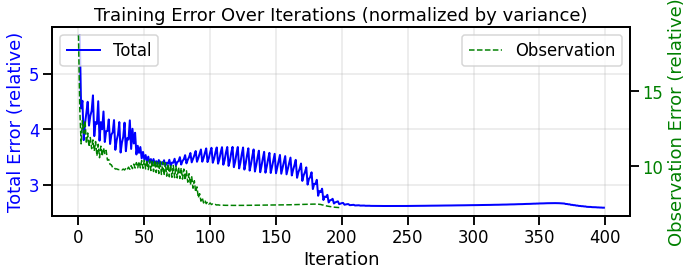

In [123]:
# Plot training error
fig, ax = plt.subplots(figsize=(10, 4))

data_var = np.var(np.hstack(y_list_normalized))
rel_error_history = [e / data_var for e in result.error_history]
rel_obs_error_history = [e / data_var for e in model.obs_error_history_]

ax.plot(rel_error_history, 'b-', linewidth=2, label='Total')
ax2 = ax.twinx()
ax2.plot(rel_obs_error_history, 'g--', linewidth=1.5, label='Observation')
ax2.set_ylabel('Observation Error (relative)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax.set_xlabel('Iteration')
ax.set_ylabel('Total Error (relative)', color='b')
ax.tick_params(axis='y', labelcolor='b')
ax.set_title('Training Error Over Iterations (normalized by variance)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.2 Learned Latent States

These are the low-dimensional trajectories that capture the essence of your neural activity.

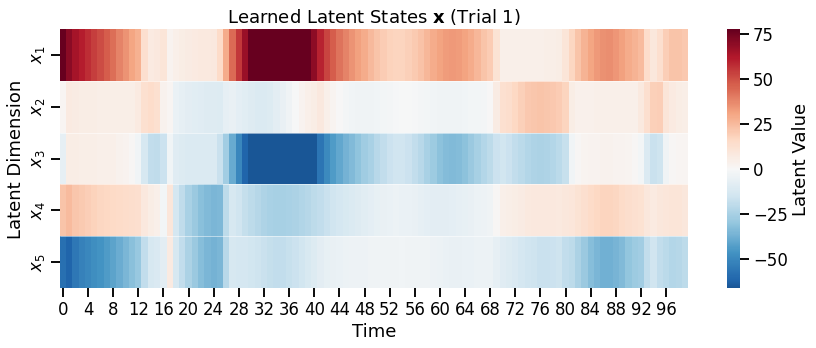

In [124]:
# Plot latent states
fig, ax = plt.subplots(figsize=(12, 5))

n_latent_to_plot = min(5, learned_x.shape[0])
data_to_plot = learned_x[:n_latent_to_plot, :]

sns.heatmap(data_to_plot, ax=ax, cmap='RdBu_r', center=0, 
            yticklabels=['$x_{%d}$' % (i+1) for i in range(n_latent_to_plot)],robust = True,
            cbar_kws={'label': 'Latent Value'})

ax.set_xlabel('Time')
ax.set_ylabel('Latent Dimension')
ax.set_title('Learned Latent States $\\mathbf{x}$ (Trial 1)')

for i in range(1, n_latent_to_plot):
    ax.axhline(i, color='white', linewidth=0.5)

plt.tight_layout()
plt.show()


### 6.3 Dynamic Coefficients

These show **which dynamics operators are active at each time**.

If you see switching patterns, it means different dynamics dominate at different times (e.g., different movement phases).

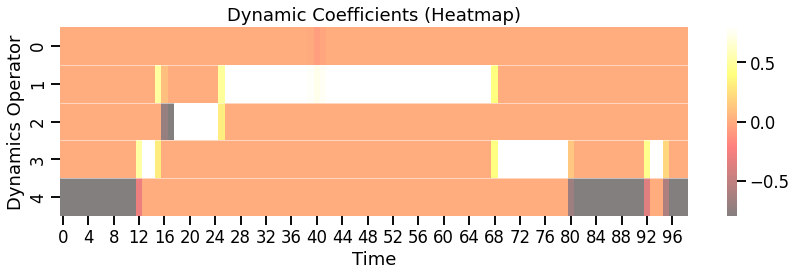

In [125]:
# Heatmap view of coefficients (often easier to read)
fig, ax = plt.subplots(figsize=(12, 4))

im = sns.heatmap(learned_c,  cmap='hot', ax = ax, alpha = 0.5, center = 0)
ax.set_xlabel('Time')
ax.set_ylabel('Dynamics Operator')
ax.set_title('Dynamic Coefficients (Heatmap)')
for i in range(1, learned_c.shape[0]):
    ax.axhline(i, color='white', linewidth=0.5)

plt.tight_layout()
plt.show()

### 6.4 Observation Matrix D

This matrix maps from latent space to observed neurons. Each column shows how one latent dimension contributes to all neurons.

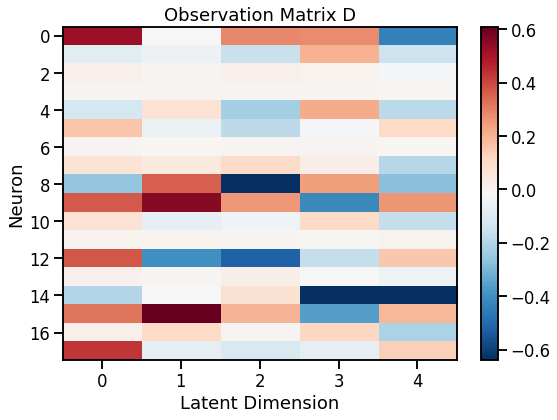

In [126]:
# Plot D matrix
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(learned_D, aspect='auto', cmap='RdBu_r')
ax.set_xlabel('Latent Dimension')
ax.set_ylabel('Neuron')
ax.set_title('Observation Matrix D')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

### 6.5 Reconstruction Quality

The ultimate test: can we reconstruct the original data from our latent representation?

In [127]:
# Reconstruct the data
y_original = y_list_normalized# [0][:,:99]
y_reconstructed = model.reconstruct(y_original)

print(f"Original shape: {y_original[0].shape}")
print(f"Reconstructed shape: {y_reconstructed[0].shape}")

Original shape: (18, 100)
Reconstructed shape: (18, 100)


### Show reconstructed data

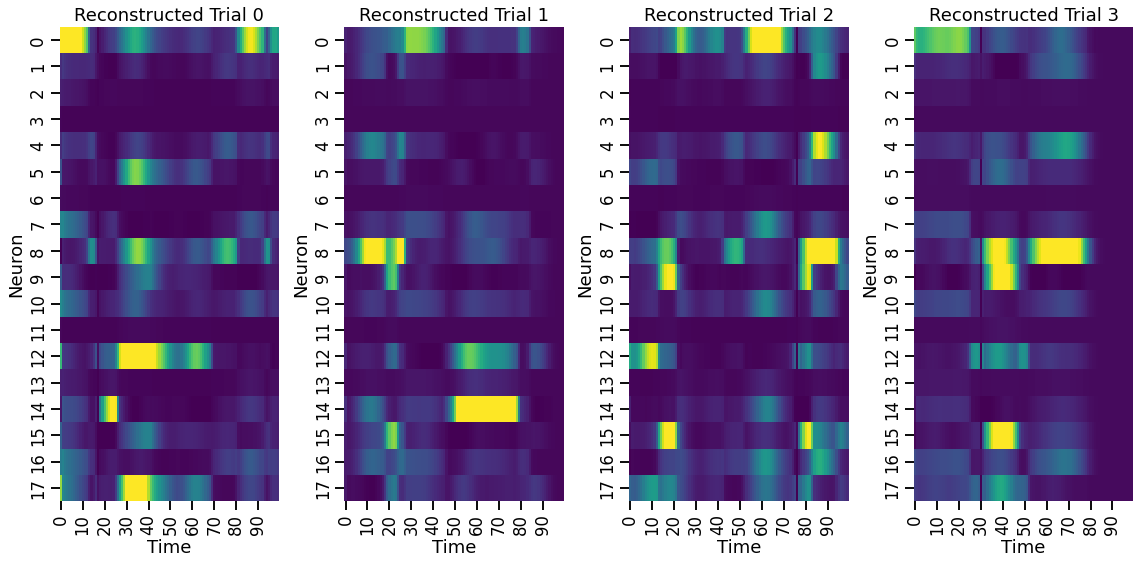

In [146]:
fig, axes = plt.subplots(1, 4, figsize=(16, 8))


for trial_c, trial in enumerate([0,1,2,3]):

    sns.heatmap(y_reconstructed[trial], ax=axes[trial_c], cmap='viridis', cbar=False, robust = True)
    axes[trial_c].set_title('Reconstructed Trial %d'%trial)
    axes[trial_c].set_xlabel('Time')
    axes[trial_c].set_ylabel('Neuron')

plt.tight_layout()
plt.show()

---
## Step 7: Analyze the Dynamics Operators

Each F matrix represents a different "mode" of dynamics. Let's visualize them.

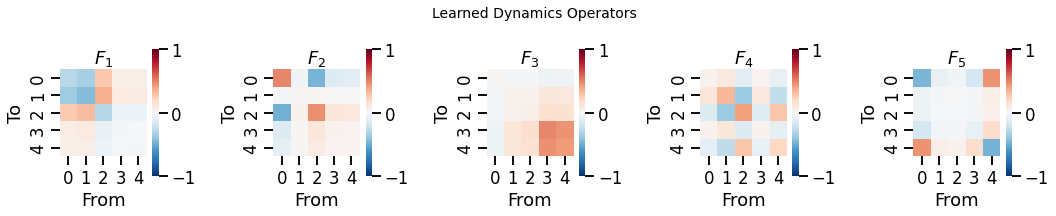

In [147]:
# Plot all F matrices
n_F = len(learned_F)
n_cols = min(5, n_F)
n_rows = int(np.ceil(n_F / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
axes = axes.flatten() if n_F > 1 else [axes]

for m, ax in enumerate(axes[:n_F]):
    sns.heatmap(learned_F[m], cmap='RdBu_r', vmin=-1, vmax=1, center=0,
                ax=ax, cbar=True, square=True)
    ax.set_title(f'$F_{{{m+1}}}$')
    ax.set_xlabel('From')
    ax.set_ylabel('To')

# Hide unused subplots
for ax in axes[n_F:]:
    ax.axis('off')

plt.suptitle('Learned Dynamics Operators', fontsize=14)
plt.tight_layout()
plt.show()

---
## Step 8: Using Your Own Data

Here's a quick template for applying dLDS to your own data:

In [148]:
# Template for your own data
print("""
# Quick Start Template
# ====================

# 1. Load your data as a list of (neurons × time) arrays
your_data = [trial1, trial2, trial3, ...]  # each is (n_neurons, n_timepoints)

# 2. Normalize (important!)
your_data_normalized = normalize_your_data(your_data)  # see Step 2 above

# 3. Create and fit model
model = dLDS_with_latents(
    num_subdyns=10,       # adjust based on complexity
    latent_dim=15,        # adjust based on data
    reg_term=3.5,
    max_iter=200
)

result = model.fit(your_data_normalized, latent_dim=15, init_D='pca')

# 4. Get results
latent_states = result.x           # list of latent trajectories
coefficients = result.dynamic_coefficients  # list of coefficient time series
dynamics_operators = result.F      # list of F matrices
observation_matrix = result.D      # D matrix

# 5. Reconstruct
y_hat = model.reconstruct(your_data_normalized[0])
""")


# Quick Start Template
# ====================

# 1. Load your data as a list of (neurons × time) arrays
your_data = [trial1, trial2, trial3, ...]  # each is (n_neurons, n_timepoints)

# 2. Normalize (important!)
your_data_normalized = normalize_your_data(your_data)  # see Step 2 above

# 3. Create and fit model
model = dLDS_with_latents(
    num_subdyns=10,       # adjust based on complexity
    latent_dim=15,        # adjust based on data
    reg_term=3.5,
    max_iter=200
)

result = model.fit(your_data_normalized, latent_dim=15, init_D='pca')

# 4. Get results
latent_states = result.x           # list of latent trajectories
coefficients = result.dynamic_coefficients  # list of coefficient time series
dynamics_operators = result.F      # list of F matrices
observation_matrix = result.D      # D matrix

# 5. Reconstruct
y_hat = model.reconstruct(your_data_normalized[0])



---
summary:


1. Load and preprocess neural data
2. Normalize data (crucial for convergence!)
3. Set up and fit a dLDS model
4. Extract latent states, dynamics, and coefficients
5. Visualize and interpret the results

